### Case Study - Data visualization.

## Objectives

We are trying to identify factors that contribute to the unique market situation in Singapore. Singapore has a higher rate of churn than other markets and there is something in the data that, once uncovered, will allow you to make a hypothesis.

The deliverable will be a storyboard. The story should begin with descriptions of the data along with a summary of the business opportunity. The rest of the story details the process of the investigation and puts the findings into context. Finally, end with some discussion and suggestions about next steps in the process.

 ### Data Ingestion.

Use the 'magic command' to ingest the data (performs cleaning as well). Saves cleaned data as "aavail-target.csv" in the data subdirectory. If the target file already exists use "overwrite=True" as needed  

!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams.csv

cleaned_df = pd.read_csv("data/aavail-target.csv")  
cleaned_df.head()

Alternatively, step through the code cells below.

In [1]:
# All the imports you will need for this case study
import os
import pandas as pd
import numpy as np
import sqlite3

# Specify the directory you saved the data in
data_dir = "data"

Let's connect to this using the sqlite3 Python package with the function shown below.

In [2]:
def connect_db(file_path):
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db\n")
    except:
        print("...unsuccessful connection\n")
    return(conn)

Let's make the connection to the database and see the table names 

In [3]:
# Make the connection to the database
conn = connect_db(os.path.join(data_dir, "aavail-customers.db"))

# Print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

...successfully connected to db

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


* Now that we have extracted the relevant data from the DB, let's query the database and extract the following data into a Pandas DataFrame.

      - Customer ID (integer)
      - Last name
      - First name
      - DOB
      - City
      - State
      - Country
      - Gender

In [4]:
query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender
FROM CUSTOMER cu
INNER JOIN COUNTRY co
ON cu.country_id = co.country_id;
"""

_data = [d for d in conn.execute(query)]
columns = ["customer_id", "last_name", "first_name", "DOB", "city", "state", "country", "gender"]
df_db = pd.DataFrame(_data, columns=columns)
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country,gender
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m


* Now that we have the data from AAVAIL db, our next steps will be to extract the relevant data from the streams CSV file.
* For each customer_id we have to check if a customer has stopped their subscription or not and save it in a dictionary or another data container.

In [5]:
df_streams = pd.read_csv(os.path.join(data_dir, r"aavail-streams.csv"))
df_streams.head()

,customer_id,stream_id,date,invoice_item_id,subscription_stopped
0,1,1420.0,2018-10-21,2.0,0
1,1,1343.0,2018-10-23,2.0,0
2,1,1756.0,2018-11-05,2.0,0
3,1,1250.0,2018-11-06,2.0,0
4,1,1324.0,2018-11-12,2.0,0


In [6]:
customer_ids = df_streams['customer_id'].values
unique_ids = np.unique(df_streams['customer_id'].values)
streams = df_streams['subscription_stopped'].values
has_churned = [0 if streams[customer_ids==uid].max() > 0 else 1 for uid in unique_ids]
df_churn = pd.DataFrame({"customer_id": unique_ids,"is_subscriber": has_churned})
df_churn.head()

,customer_id,is_subscriber
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1


#### Exploratory Data Analysis

Sometimes it is known in advance which types of data integrity issues to expect, but other times it is during the Exploratory Data Analysis (EDA) process that these issues are identified. 

After extracting data it is important to include checks for quality assurance even on the first pass through the AI workflow.  Let's combine the data into a single structure and provide a couple checks for quality assurance.

**Implementation of checks for Quality Assurance**

- Remove any repeat customers based on customer_id
- Remove stream data that do not have an associated stream_id
- Check for missing values

In [7]:
print("\nCleaning Summary\n{}".format("-"*35))
duplicate_rows = df_db.duplicated()
if True in duplicate_rows:
    df_db = df_db[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

missing_stream_ids = np.isnan(df_streams['stream_id'])    
if True in missing_stream_ids:
    df_streams = df_streams[~missing_stream_ids]
print("Removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Removed 7 duplicate rows
Removed 1164 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id      0
last_name        0
first_name       0
DOB              0
city             0
state          300
country          0
gender           0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
invoice_item_id         0
subscription_stopped    0
dtype: int64


**Combine the data into a single data structure**

The two most convenient structures for this task are Pandas dataframes and NumPy arrays. At a minimum ensure that the structure accommodates the following.

- A column for customer_id
- A column for country
- A column for age that is created from DOB
- A column customer_name that is created from first_name and last_name
- A column to indicate churn called is_subscriber
- A column that indicates subscriber_type that comes from invoice_item
- A column to indicate the total num_streams

In [8]:
import scipy.stats as stats

df_clean = df_churn.copy()
df_clean = df_clean[np.in1d(df_clean['customer_id'].values,df_db['customer_id'].values)]
unique_ids = df_clean['customer_id'].values

# Ensure we are working with correctly ordered customer_ids df_db
if not np.array_equal(df_clean['customer_id'],df_db['customer_id']): 
    raise Exception("indexes are out of order or unmatched---needs to fix")

# Query the db t0 create a invoice item map
query = """
SELECT i.invoice_item_id, i.invoice_item
FROM INVOICE_ITEM i;
"""

# Variables for new df creation
invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}
streams_stopped = df_streams['subscription_stopped'].values
streams_cid = df_streams['customer_id'].values
streams_iid = df_streams['invoice_item_id'].values
subscriber_invoice_mode = [stats.mode(streams_iid[streams_cid==uid])[0][0] for uid in unique_ids]

# Create the new df
df_clean['country'] = df_db['country']
df_clean['age'] = np.datetime64('today') - pd.to_datetime(df_db['DOB'])
df_clean['customer_name'] = df_db['first_name'] + " " + df_db['last_name']
df_clean['subscriber_type'] = [invoice_item_map[int(sim)] for sim in subscriber_invoice_mode]
df_clean['num_streams'] = [streams_stopped[streams_cid==uid].size for uid in unique_ids]

# Convert age to days
df_clean['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_clean['age'].values]

df_clean.head()

,customer_id,is_subscriber,country,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,21,Kasen Todd,aavail_premium,23
1,2,0,singapore,30,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,22,Lillian Carey,aavail_premium,22
3,4,1,united_states,20,Beau Christensen,aavail_basic,19
4,5,1,singapore,21,Ernesto Gibson,aavail_premium,23


Check whether the script and the notebook produced the same result  
print(cleaned_df.shape)  
print(df_clean.shape)  
print(cleaned_df.equals(df_clean))  

#### Investigative Visualization

Data visualization is the discipline of trying to understand data by placing it in a visual context so that patterns, trends and correlations that might not otherwise be detected can be exposed. The tables we just created above are difficult to navigate and it can be useful to use a simple plot to summarize the data. It is possible that both a table and a plot might be needed to communicate the findings and one common practice is to include an appendix in the deliverable. 

The goal here is to see what factors are influencing the Singapore situation and let's start by analyzing these factors.

In [9]:
# Import data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
print(pd.crosstab(df_clean.is_subscriber, df_clean.country))

country        singapore  united_states
is_subscriber                          
0                    181            108
1                    119            592


The values above show that there are 181 non-subscribers in the Singapore and 108 in US and there are 119 subscribers in Singapore and 592 in US. We can understand that there are more subscribers in the US than in Singapore.

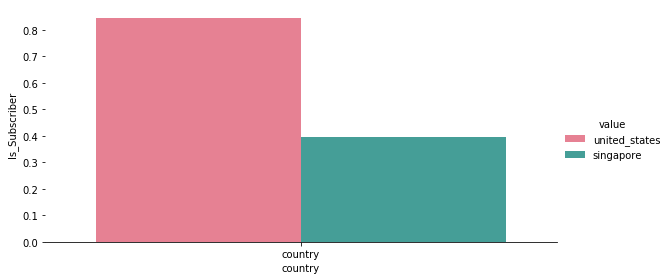

In [11]:
# Create a new temporary dataframe to help us plot these variables.
df1 = pd.melt(df_clean, id_vars=['is_subscriber'], value_vars=["country"],
              var_name='country' )

# Create a factorplot
g = sns.catplot( x="country", y="is_subscriber", hue='value', data=df1,
                   height=4, aspect=2, kind="bar", palette="husl", ci=None )
g.despine(left=True)
g.set_ylabels("Is_Subscriber")
plt.show()

Most features have a wider range of numbers, not just 0 or 1. So for those it makes sense to look at how the distribution of the data differs for the people that are non-subscribers and the people that are subscribers. Let's add more dimensions in the data and see how what exactly is going on in Singapore.

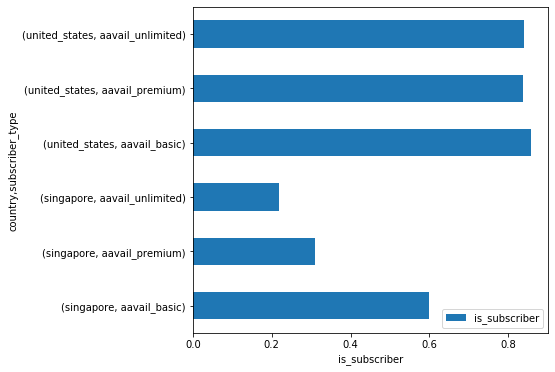

In [12]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table1 = pd.pivot_table(df_clean, index = ['country', 'subscriber_type'], values = 'is_subscriber')
table1.plot(kind='barh',ax=ax1)
ax1.set_xlabel("is_subscriber");

From the analysis above we can see that the number of `unlimited` subscribers in Singapore is rather low as compared to premium and basic subscribers. Perhaps the basic subscribers in Singapore are more likely to churn.

C:\Users\Michael\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Michael\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


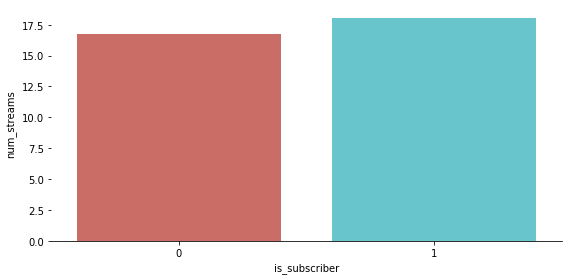

In [13]:
# Create a factorplot
j = sns.factorplot( x="is_subscriber", y="num_streams", data=df_clean, size=4, aspect=2, kind="bar", palette= "hls", ci=None )
j.despine(left=True)
j.set_ylabels("num_streams")
plt.show()

The above analysis shows the average `num_streams` among current subscribers and non-subscribers. This information is not enough and we will need to create an age distribution for different countries. Let's analyze `num_streams` for different countries.

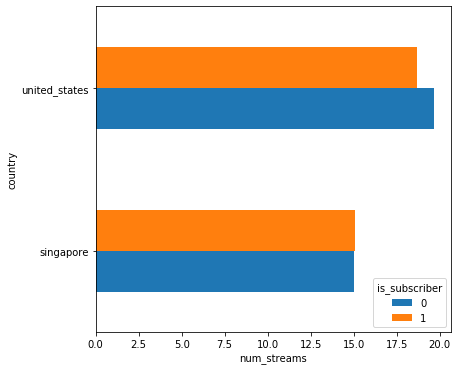

In [14]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table2 = df_clean.pivot_table('num_streams', index='country', columns='is_subscriber')
table2.plot(kind='barh',ax=ax1)
ax1.set_xlabel("num_streams");

The analysis above shows that both subscribers and non-subscribers have approximately 15.0 number of streams in Singapore. s such it may not be an important feature but we need to perform more data analysis to prove that.

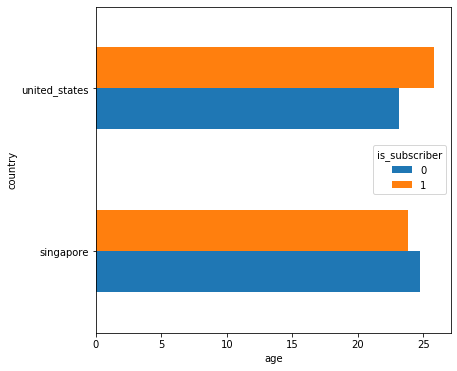

In [15]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table3 = df_clean.pivot_table('age', index='country', columns='is_subscriber')
table3.plot(kind='barh',ax=ax1)
ax1.set_xlabel("age");

The analysis above shows that the average age of both subscribers and non-subscribers is almost 25 years of age in Singapore. This gives us an important insight to analyze the average age for each subscriber_type.

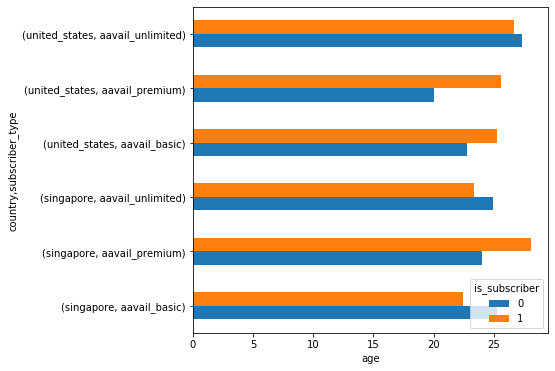

In [16]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table4 = df_clean.pivot_table('age', index=['country','subscriber_type'], columns='is_subscriber')
table4.plot(kind='barh',ax=ax1)
ax1.set_xlabel("age");

We can see that the average age among basic subscribers is higher than 25 and for premium subscribers it is approximately 22. For unlimited subscribers the average age is higher than 25 in Singapore. From this analysis we can infer that the average age for basic subscribers and unlimited subscribers in Singapore is less than, or equal to, 25.

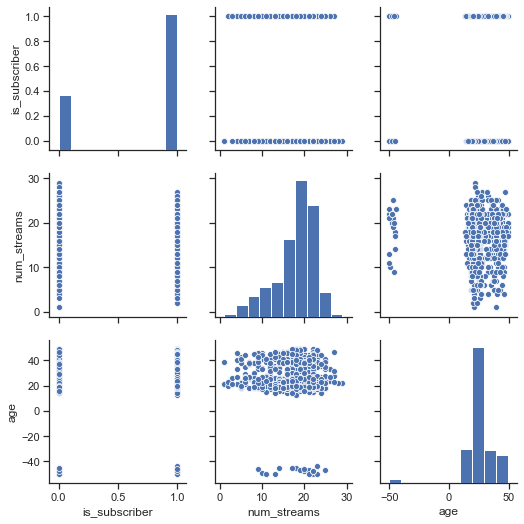

In [17]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = ['is_subscriber', 'num_streams', 'age']

axes = sns.pairplot(df_clean, vars=columns, palette="husl")

### Findings from the analysis of our Features

**The goal of our data analysis is to find factors that are influencing the Singapore situation**

Here are some of the findings of the data analysis:

- There are more subscribers in the US than in Singapore.
- The number of unlimited subscribers in Singapore is low compared to premium and basic subscribers.
- The basic subscribers in Singapore are more prone to churn out soon compared to premium and unlimited.
- Both the subscribers and non-subscribers have approximately 15.0 number of streams in Singapore.
- The average age of both subscribers and non-subscribers is almost 25 years of age in Singapore
- The average age for basic subscribers and unlimited subscribers in Singapore <= 25.
    

### Next Steps

From the findings abover we can surmise that some of the important factors influencing our goal are `subscriber_type`, `age` `and` location but our findings do not provide any specific or deep insights on the underlying factors.

Some of the next steps that can be performed are:
* Deep Dive Data analysis on each feature - We can use PCA (Principal Component Analysis) to explore the variations in variables.
* Hypothesis testing  - We can hypothesize each feature and it's importance.
* We can also calculate multiple types of aggregations for any given feature for better data explorations.